# Test 6D Pose Estimation con PoseEstimator

Questo notebook permette di:
1. **Carica dataset LineMOD** con split ufficiale train/test
2. **Inizializza PoseEstimator** (ResNet-50 backbone + regression head)
3. **Training**
4. **Valutazione con ADD metric** sul test set

### Sezione da Eseguire sempre
Esegui sempre questa sezione per configurare l'ambiente. Poi scegli:
- **Training completo**
- **Test modello già trainato**

In [4]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from tqdm import tqdm

# Configura matplotlib per notebook
%matplotlib inline

# Aggiungi il path del progetto
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from dataset.custom_dataset import create_pose_dataloaders
from models.pose_estimator import PoseEstimator
from utils.losses import PoseLoss
from utils.metrics import load_all_models, load_models_info, compute_add_batch
from utils.transforms import quaternion_to_rotation_matrix
from config import Config

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"🔢 Batch size: {Config.POSE_BATCH_SIZE}")

✅ Setup completato
📂 Project root: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation
🎯 Dataset: LineMOD
🖥️  Device: mps
📊 Image size: 224x224
🔢 Batch size: 128


In [5]:
# Carica dataset con split ufficiale train/test
print("📦 Caricamento PoseDataset con split ufficiale...\n")

train_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.DATA_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE  # Adaptive: 0 on MPS, optimal on CUDA/CPU
)

print(f"✅ Dataset caricato:")
print(f"   Train batches: {len(train_loader)} (batch_size={Config.POSE_BATCH_SIZE})")
print(f"   Test batches: {len(test_loader)}")
print(f"   Train samples: ~{len(train_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Test samples: ~{len(test_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Crop margin: {Config.POSE_CROP_MARGIN * 100:.0f}%")
print(f"   Output size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"   Workers: {Config.NUM_WORKERS_POSE} (adaptive per {Config.DEVICE})")

📦 Caricamento PoseDataset con split ufficiale...

🔄 Preloading metadata for 13 folders...
🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 3759 train samples
🚀 Cached 13 gt.yml and 13 info.yml files
✅ PoseDataset initialized: 3759 train samples
🚀 Cached 13 gt.yml and 13 info.yml files
🔄 Preloading metadata for 13 folders...
🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 21218 test samples
🚀 Cached 13 gt.yml and 13 info.yml files

📊 Pose DataLoaders created:
   Training samples: 3759
   Training batches: 30
   Test samples: 21218
   Test batches: 166
✅ Dataset caricato:
   Train batches: 30 (batch_size=128)
   Test batches: 166
   Train samples: ~3840
   Test samples: ~21248
   Crop margin: 10%
   Output size: 224x224
   Workers: 0 (adaptive per mps)
✅ PoseDataset initialized: 21218 test samples
🚀 Cached 13 gt.yml and 13 info.yml files

📊 Pose DataLoaders created:
   Training samples: 3759
   Training batches: 30
   Test samples: 21218
   Test batch

In [3]:
# # Visualizza alcuni sample del dataset
# print("\n🖼️  Visualizzazione sample del training set\n")

# # Prendi un batch
# batch = next(iter(train_loader))
# images = batch['rgb_crop']  # [B, 3, 224, 224]
# quaternions = batch['quaternion']  # [B, 4]
# translations = batch['translation']  # [B, 3]
# obj_ids = batch['obj_id']  # [B]

# # Visualizza 4 sample
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# axes = axes.flatten()

# for i in range(min(4, len(images))):
#     # Denormalizza immagine (ImageNet normalization)
#     img = images[i].permute(1, 2, 0).cpu().numpy()
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     img = img * std + mean
#     img = np.clip(img, 0, 1)
    
#     # Ground truth
#     quat = quaternions[i].cpu().numpy()
#     trans = translations[i].cpu().numpy()
#     obj_id = obj_ids[i].item()
    
#     axes[i].imshow(img)
#     axes[i].set_title(
#         f"Object {obj_id:02d}\n"
#         f"Quat: [{quat[0]:.2f}, {quat[1]:.2f}, {quat[2]:.2f}, {quat[3]:.2f}]\n"
#         f"Trans: [{trans[0]:.1f}, {trans[1]:.1f}, {trans[2]:.1f}] mm",
#         fontsize=10
#     )
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()

# print(f"✅ Visualizzazione completata!")
# print(f"   Crop centrato sul bbox con {Config.POSE_CROP_MARGIN * 100:.0f}% margin")
# print(f"   Quaternion normalizzato (||q|| = 1)")
# print(f"   Translation in millimetri (mm)")

### Inizializza Modello PoseEstimator

ResNet-50 backbone (pretrained ImageNet) + regression head (Linear 2048→1024→512→7).
Output: 4D quaternion [qw, qx, qy, qz] + 3D translation [tx, ty, tz]

In [4]:
# Inizializza PoseEstimator con backbone SBLOCCATO (Fase 1 ottimizzazione)
print("🤖 Inizializzazione PoseEstimator...\n")

model = PoseEstimator(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False  # ✅ SBLOCCATO per fine-tuning completo
).to(Config.DEVICE)

print(f"✅ Modello inizializzato:")
print(f"   Backbone: ResNet-50 (pretrained ImageNet)")
print(f"   Dropout: {Config.POSE_DROPOUT}")
print(f"   Output: 4D quaternion + 3D translation")

# Conta parametri
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parametri del modello:")
print(f"   Parametri totali: {total_params:,}")
print(f"   Parametri trainable: {trainable_params:,}")
print(f"   Percentuale trainable: {100 * trainable_params / total_params:.1f}%")

print(f"\n💡 Modalità: Backbone SBLOCCATO (Fase 1)")
print(f"   Tutti i parametri trainable (~25M)")
print(f"   Fine-tuning completo ResNet-50 + regression head")
print(f"   Training più lento ma risultati migliori")

🤖 Inizializzazione PoseEstimator...



/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: ResNet-50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.3
✅ Modello inizializzato:
   Backbone: ResNet-50 (pretrained ImageNet)
   Dropout: 0.3
   Output: 4D quaternion + 3D translation

📊 Parametri del modello:
   Parametri totali: 26,137,671
   Parametri trainable: 26,137,671
   Percentuale trainable: 100.0%

💡 Modalità: Backbone SBLOCCATO (Fase 1)
   Tutti i parametri trainable (~25M)
   Fine-tuning completo ResNet-50 + regression head
   Training più lento ma risultati migliori


### Training

Training rapido per testare il pipeline. Per risultati migliori, usa 50 epoche con backbone unfrozen.

In [ ]:
# ⚡ FASE 1: TRAINING OTTIMIZZATO
# - Backbone sbloccato
# - Learning rate differenziato
# - Warmup + ReduceLROnPlateau

EPOCHS = 30  # ✅ Ridotto: backbone unfrozen converge più velocemente
WARMUP_EPOCHS = 5  # ✅ Warmup graduale per stabilizzare training
EXPERIMENT_NAME = "pose_stable_train30"

# Learning rates differenziati
LR_BACKBONE = 1e-5  # 10x più basso per fine-tuning delicato
LR_HEAD = 1e-4      # Standard per regression head

# Gradient Accumulation
ACCUMULATION_STEPS = 4
EFFECTIVE_BATCH_SIZE = Config.POSE_BATCH_SIZE * ACCUMULATION_STEPS

print(f"⚡ FASE 1 - Training Ottimizzato:")
print(f"   Esperimento: {EXPERIMENT_NAME}")
print(f"   Epoche: {EPOCHS} (+ {WARMUP_EPOCHS} warmup)")
print(f"   Batches per epoca: {len(train_loader)}")
print(f"   🚀 LR Backbone: {LR_BACKBONE:.2e} (fine-tuning delicato)")
print(f"   🚀 LR Head: {LR_HEAD:.2e} (standard)")
print(f"   Batch size: {Config.POSE_BATCH_SIZE}")
print(f"   🚀 Accumulation steps: {ACCUMULATION_STEPS}")
print(f"   🚀 Effective batch size: {EFFECTIVE_BATCH_SIZE}")
print(f"   Lambda translation: {Config.LAMBDA_TRANS}")
print(f"   Lambda rotation: {Config.LAMBDA_ROT}")
print(f"   Device: {Config.DEVICE}")

# AMP per CUDA
use_amp = Config.DEVICE == 'cuda' and hasattr(torch.cuda, 'amp')
if use_amp:
    print(f"   🚀 AMP enabled (FP16 training)")
    scaler = torch.cuda.amp.GradScaler()
else:
    print(f"   ⚠️  AMP disabled (device={Config.DEVICE})")
    scaler = None

# Stima tempo (più lungo con backbone unfrozen)
estimated_time = 5 * len(train_loader) * EPOCHS / 3600  # ore
print(f"\n⏱️  Tempo stimato: ~{estimated_time:.1f} ore")

print(f"\n💡 Miglioramenti Fase 1:")
print(f"   ✓ Backbone sbloccato: fine-tuning completo (~25M params)")
print(f"   ✓ Learning rate differenziato: backbone 10x più basso")
print(f"   ✓ Warmup: {WARMUP_EPOCHS} epoche per stabilizzare")
print(f"   ✓ ReduceLROnPlateau: LR si riduce solo se loss stagna")
print(f"   ✓ Gradient Accumulation: effective batch {EFFECTIVE_BATCH_SIZE}")

# Setup training con learning rate differenziato
criterion = PoseLoss(
    lambda_trans=Config.LAMBDA_TRANS,
    lambda_rot=Config.LAMBDA_ROT
)

# ✅ OTTIMIZZAZIONE: Learning rate differenziato per backbone e head
optimizer = torch.optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': LR_BACKBONE, 'name': 'backbone'},
    {'params': model.pose_head.parameters(), 'lr': LR_HEAD, 'name': 'head'}
], weight_decay=Config.POSE_WEIGHT_DECAY)

# ✅ OTTIMIZZAZIONE: ReduceLROnPlateau invece di CosineAnnealing
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      # Riduce LR di 50% quando stagna
    patience=5,      # Attende 5 epoche prima di ridurre
    min_lr=1e-7      # LR minimo
)

# Crea struttura cartelle
checkpoint_dir = project_root / 'checkpoints' / 'pose' / EXPERIMENT_NAME
checkpoint_dir.mkdir(parents=True, exist_ok=True)

weights_dir = checkpoint_dir / 'weights'
weights_dir.mkdir(exist_ok=True)

# Salva configurazione
config_file = checkpoint_dir / 'args.yaml'
import yaml
training_config = {
    'phase': 'Phase 1 - Optimized',
    'epochs': EPOCHS,
    'warmup_epochs': WARMUP_EPOCHS,
    'lr_backbone': float(LR_BACKBONE),
    'lr_head': float(LR_HEAD),
    'batch_size': Config.POSE_BATCH_SIZE,
    'accumulation_steps': ACCUMULATION_STEPS,
    'effective_batch_size': EFFECTIVE_BATCH_SIZE,
    'use_amp': use_amp,
    'lambda_trans': Config.LAMBDA_TRANS,
    'lambda_rot': Config.LAMBDA_ROT,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'scheduler': 'ReduceLROnPlateau',
    'device': str(Config.DEVICE),
    'image_size': Config.POSE_IMAGE_SIZE,
    'crop_margin': Config.POSE_CROP_MARGIN,
}
with open(config_file, 'w') as f:
    yaml.dump(training_config, f, default_flow_style=False)

print(f"\n📁 Checkpoint directory: {checkpoint_dir}")
print(f"   ├── args.yaml")
print(f"   ├── results.csv")
print(f"   └── weights/")
print(f"       ├── best.pt")
print(f"       └── last.pt\n")

# Training loop con warmup
history = {'train_loss': [], 'train_trans': [], 'train_rot': [], 'lr_backbone': [], 'lr_head': []}
best_loss = float('inf')
best_epoch = 0

results_file = checkpoint_dir / 'results.csv'
with open(results_file, 'w') as f:
    f.write('epoch,train_loss,train_trans_loss,train_rot_loss,lr_backbone,lr_head\n')

for epoch in range(EPOCHS):
    # ✅ WARMUP: Aumenta gradualmente LR nelle prime WARMUP_EPOCHS
    if epoch < WARMUP_EPOCHS:
        warmup_factor = (epoch + 1) / WARMUP_EPOCHS
        for param_group in optimizer.param_groups:
            if param_group['name'] == 'backbone':
                param_group['lr'] = LR_BACKBONE * warmup_factor
            else:  # head
                param_group['lr'] = LR_HEAD * warmup_factor
        print(f"🔥 Warmup epoch {epoch+1}/{WARMUP_EPOCHS} - LR scale: {warmup_factor:.2f}")
    
    model.train()
    epoch_loss = 0
    epoch_trans = 0
    epoch_rot = 0
    
    optimizer.zero_grad()
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for batch_idx, batch in enumerate(pbar):
        # Move to device
        images = batch['rgb_crop'].to(Config.DEVICE)
        gt_quaternion = batch['quaternion'].to(Config.DEVICE)
        gt_translation = batch['translation'].to(Config.DEVICE)
        
        # Forward pass with AMP (if enabled)
        if use_amp:
            with torch.cuda.amp.autocast():
                pred_quaternion, pred_translation = model(images)
                loss_dict = criterion(
                    pred_quaternion, pred_translation,
                    gt_quaternion, gt_translation
                )
                loss = loss_dict['total'] / ACCUMULATION_STEPS
        else:
            pred_quaternion, pred_translation = model(images)
            loss_dict = criterion(
                pred_quaternion, pred_translation,
                gt_quaternion, gt_translation
            )
            loss = loss_dict['total'] / ACCUMULATION_STEPS
        
        # Backward pass
        if use_amp:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        
        # Update weights every ACCUMULATION_STEPS
        if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
            if use_amp:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
        
        # Update metrics
        epoch_loss += loss_dict['total'].item()
        epoch_trans += loss_dict['trans'].item()
        epoch_rot += loss_dict['rot'].item()
        
        # Update progress bar
        current_lr_backbone = optimizer.param_groups[0]['lr']
        current_lr_head = optimizer.param_groups[1]['lr']
        pbar.set_postfix({
            'loss': f"{loss_dict['total'].item():.4f}",
            'trans': f"{loss_dict['trans'].item():.4f}",
            'rot': f"{loss_dict['rot'].item():.2f}",
            'lr_bb': f"{current_lr_backbone:.2e}",
            'lr_hd': f"{current_lr_head:.2e}"
        })
    
    # Epoch statistics
    num_batches = len(train_loader)
    avg_loss = epoch_loss / num_batches
    avg_trans = epoch_trans / num_batches
    avg_rot = epoch_rot / num_batches
    
    current_lr_backbone = optimizer.param_groups[0]['lr']
    current_lr_head = optimizer.param_groups[1]['lr']
    
    history['train_loss'].append(avg_loss)
    history['train_trans'].append(avg_trans)
    history['train_rot'].append(avg_rot)
    history['lr_backbone'].append(current_lr_backbone)
    history['lr_head'].append(current_lr_head)
    
    # Salva risultati epoch
    with open(results_file, 'a') as f:
        f.write(f"{epoch+1},{avg_loss:.6f},{avg_trans:.6f},{avg_rot:.6f},{current_lr_backbone:.8e},{current_lr_head:.8e}\n")
    
    print(f"\n📊 Epoch {epoch+1}/{EPOCHS} Summary:")
    print(f"   Loss: {avg_loss:.4f} | Trans: {avg_trans:.4f} | Rot: {avg_rot:.2f}")
    print(f"   LR Backbone: {current_lr_backbone:.2e} | LR Head: {current_lr_head:.2e}")
    
    # ✅ SCHEDULER: Riduci LR se loss stagna (dopo warmup)
    if epoch >= WARMUP_EPOCHS:
        scheduler.step(avg_loss)
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        best_path = weights_dir / 'best.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'loss_trans': avg_trans,
            'loss_rot': avg_rot,
            'config': training_config,
        }, best_path)
        print(f"   💾 Best model salvato: {best_path.relative_to(project_root)}")
    
    # Save last model
    last_path = weights_dir / 'last.pt'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'loss_trans': avg_trans,
        'loss_rot': avg_rot,
        'config': training_config,
    }, last_path)
    
    # ✅ EARLY STOPPING: Ferma se non migliora per 10 epoche
    if epoch - best_epoch >= 10 and epoch >= WARMUP_EPOCHS:
        print(f"\n⚠️  Early stopping! Loss non migliora da {epoch - best_epoch} epoche")
        print(f"   Best loss: {best_loss:.4f} @ epoch {best_epoch + 1}")
        break
    
    print()

print(f"✅ Training Fase 1 completato!")
print(f"   Best loss: {best_loss:.4f} @ epoch {best_epoch + 1}")
print(f"   Modelli salvati in: {checkpoint_dir.relative_to(project_root)}")
print(f"   📁 Struttura:")
print(f"      ├── args.yaml")
print(f"      ├── results.csv")
print(f"      └── weights/")
print(f"          ├── best.pt (best loss: {best_loss:.4f})")
print(f"          └── last.pt (last epoch)")

print(f"\n🚀 Ottimizzazioni Fase 1:")
print(f"   • Backbone sbloccato: fine-tuning completo")
print(f"   • Learning rate differenziato: {LR_BACKBONE:.2e} (bb) / {LR_HEAD:.2e} (head)")
print(f"   • Warmup: {WARMUP_EPOCHS} epoche")
print(f"   • ReduceLROnPlateau: adattivo")
print(f"   • Early stopping: patience 10 epoche")
print(f"   • Gradient Accumulation: {ACCUMULATION_STEPS}x")

# Aggiorna variabile globale per celle successive
checkpoint_path = weights_dir / 'best.pt'

⚡ FASE 1 - Training Ottimizzato:
   Esperimento: pose_stable_train30
   Epoche: 30 (+ 5 warmup)
   Batches per epoca: 30
   🚀 LR Backbone: 1.00e-05 (fine-tuning delicato)
   🚀 LR Head: 1.00e-04 (standard)
   Batch size: 128
   🚀 Accumulation steps: 4
   🚀 Effective batch size: 512
   Lambda translation: 1.0
   Lambda rotation: 10.0
   Device: mps
   ⚠️  AMP disabled (device=mps)

⏱️  Tempo stimato: ~1.2 ore

💡 Miglioramenti Fase 1:
   ✓ Backbone sbloccato: fine-tuning completo (~25M params)
   ✓ Learning rate differenziato: backbone 10x più basso
   ✓ Warmup: 5 epoche per stabilizzare
   ✓ ReduceLROnPlateau: LR si riduce solo se loss stagna
   ✓ Gradient Accumulation: effective batch 512
✅ PoseLoss initialized
   λ_trans: 1.0
   λ_rot: 10.0

📁 Checkpoint directory: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/pose_stable_train30
   ├── args.yaml
   ├── results.csv
   └── weights/
       ├── best.pt
       └── last.pt

🔥 Warmup epoch 1/5

Epoch 1/30:  50%|█████     | 15/30 [00:31<00:31,  2.11s/it, loss=291.2184, trans=281.0901, rot=1.01, lr_bb=2.00e-06, lr_hd=2.00e-05]

Epoch 1/30: 100%|██████████| 30/30 [01:02<00:00,  2.09s/it, loss=312.9954, trans=302.1129, rot=1.09, lr_bb=2.00e-06, lr_hd=2.00e-05]



📊 Epoch 1/30 Summary:
   Loss: 313.4116 | Trans: 302.8515 | Rot: 1.06
   LR Backbone: 2.00e-06 | LR Head: 2.00e-05
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt

🔥 Warmup epoch 2/5 - LR scale: 0.40


Epoch 2/30:  27%|██▋       | 8/30 [00:17<00:48,  2.20s/it, loss=304.9028, trans=294.1632, rot=1.07, lr_bb=4.00e-06, lr_hd=4.00e-05]

Epoch 2/30: 100%|██████████| 30/30 [01:04<00:00,  2.16s/it, loss=243.9601, trans=233.9547, rot=1.00, lr_bb=4.00e-06, lr_hd=4.00e-05]



📊 Epoch 2/30 Summary:
   Loss: 283.7942 | Trans: 273.3788 | Rot: 1.04
   LR Backbone: 4.00e-06 | LR Head: 4.00e-05
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt

🔥 Warmup epoch 3/5 - LR scale: 0.60


Epoch 3/30:  60%|██████    | 18/30 [00:39<00:25,  2.15s/it, loss=230.7176, trans=220.4536, rot=1.03, lr_bb=6.00e-06, lr_hd=6.00e-05]

Epoch 3/30: 100%|██████████| 30/30 [01:04<00:00,  2.14s/it, loss=244.5891, trans=233.7189, rot=1.09, lr_bb=6.00e-06, lr_hd=6.00e-05]



📊 Epoch 3/30 Summary:
   Loss: 246.8571 | Trans: 236.6803 | Rot: 1.02
   LR Backbone: 6.00e-06 | LR Head: 6.00e-05
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt

🔥 Warmup epoch 4/5 - LR scale: 0.80


Epoch 4/30:  33%|███▎      | 10/30 [00:21<00:43,  2.15s/it, loss=219.6573, trans=209.8459, rot=0.98, lr_bb=8.00e-06, lr_hd=8.00e-05]

Epoch 4/30: 100%|██████████| 30/30 [01:03<00:00,  2.10s/it, loss=199.4706, trans=190.6423, rot=0.88, lr_bb=8.00e-06, lr_hd=8.00e-05]



📊 Epoch 4/30 Summary:
   Loss: 203.8347 | Trans: 194.0943 | Rot: 0.97
   LR Backbone: 8.00e-06 | LR Head: 8.00e-05
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt

🔥 Warmup epoch 5/5 - LR scale: 1.00


Epoch 5/30:   7%|▋         | 2/30 [00:04<01:00,  2.16s/it, loss=175.2158, trans=165.5606, rot=0.97, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 5/30: 100%|██████████| 30/30 [01:02<00:00,  2.10s/it, loss=138.2794, trans=129.0660, rot=0.92, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 5/30 Summary:
   Loss: 161.8177 | Trans: 152.4196 | Rot: 0.94
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 6/30:  37%|███▋      | 11/30 [00:23<00:40,  2.15s/it, loss=126.3183, trans=117.1930, rot=0.91, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 6/30: 100%|██████████| 30/30 [01:03<00:00,  2.10s/it, loss=110.5298, trans=101.2851, rot=0.92, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 6/30 Summary:
   Loss: 127.9071 | Trans: 118.8474 | Rot: 0.91
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 7/30:  23%|██▎       | 7/30 [00:15<00:49,  2.14s/it, loss=107.1809, trans=98.1916, rot=0.90, lr_bb=1.00e-05, lr_hd=1.00e-04] 

Epoch 7/30: 100%|██████████| 30/30 [01:03<00:00,  2.11s/it, loss=95.4367, trans=87.8105, rot=0.76, lr_bb=1.00e-05, lr_hd=1.00e-04]  



📊 Epoch 7/30 Summary:
   Loss: 98.8253 | Trans: 90.2062 | Rot: 0.86
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 8/30:  70%|███████   | 21/30 [05:03<00:22,  2.55s/it, loss=73.2783, trans=64.9028, rot=0.84, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 8/30: 100%|██████████| 30/30 [05:21<00:00, 10.71s/it, loss=72.9660, trans=64.4686, rot=0.85, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 8/30 Summary:
   Loss: 81.9946 | Trans: 73.5508 | Rot: 0.84
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 9/30:  13%|█▎        | 4/30 [00:08<00:56,  2.16s/it, loss=57.2621, trans=48.9998, rot=0.83, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 9/30: 100%|██████████| 30/30 [01:02<00:00,  2.09s/it, loss=80.3303, trans=71.8234, rot=0.85, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 9/30 Summary:
   Loss: 68.6662 | Trans: 60.4624 | Rot: 0.82
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 10/30:  83%|████████▎ | 25/30 [00:53<00:10,  2.12s/it, loss=49.3582, trans=41.6027, rot=0.78, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 10/30: 100%|██████████| 30/30 [01:02<00:00,  2.08s/it, loss=56.8650, trans=49.7889, rot=0.71, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 10/30 Summary:
   Loss: 63.0196 | Trans: 54.9409 | Rot: 0.81
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 11/30:  70%|███████   | 21/30 [00:45<00:19,  2.16s/it, loss=65.7621, trans=57.7460, rot=0.80, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 11/30: 100%|██████████| 30/30 [01:03<00:00,  2.10s/it, loss=54.1594, trans=45.6323, rot=0.85, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 11/30 Summary:
   Loss: 58.9648 | Trans: 51.0188 | Rot: 0.79
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 12/30:  63%|██████▎   | 19/30 [00:40<00:23,  2.12s/it, loss=62.3604, trans=54.3207, rot=0.80, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 12/30: 100%|██████████| 30/30 [01:02<00:00,  2.09s/it, loss=62.2448, trans=53.8628, rot=0.84, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 12/30 Summary:
   Loss: 57.8524 | Trans: 49.9774 | Rot: 0.79
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 13/30:  30%|███       | 9/30 [00:19<00:44,  2.14s/it, loss=52.1121, trans=44.4872, rot=0.76, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 13/30: 100%|██████████| 30/30 [03:23<00:00,  6.77s/it, loss=64.0276, trans=56.1827, rot=0.78, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 13/30 Summary:
   Loss: 54.2579 | Trans: 46.4687 | Rot: 0.78
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 14/30:  93%|█████████▎| 28/30 [05:35<00:05,  2.69s/it, loss=53.1243, trans=45.2285, rot=0.79, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 14/30: 100%|██████████| 30/30 [05:38<00:00, 11.28s/it, loss=44.5379, trans=37.2835, rot=0.73, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 14/30 Summary:
   Loss: 51.8040 | Trans: 44.1306 | Rot: 0.77
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 15/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15/30: 100%|██████████| 30/30 [01:04<00:00,  2.14s/it, loss=76.9403, trans=70.6789, rot=0.63, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 15/30 Summary:
   Loss: 52.3508 | Trans: 44.7589 | Rot: 0.76
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04



Epoch 16/30:  30%|███       | 9/30 [00:20<00:46,  2.19s/it, loss=44.6318, trans=37.7020, rot=0.69, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 16/30: 100%|██████████| 30/30 [01:04<00:00,  2.15s/it, loss=42.9909, trans=35.2563, rot=0.77, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 16/30 Summary:
   Loss: 50.5714 | Trans: 43.1177 | Rot: 0.75
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 17/30:  47%|████▋     | 14/30 [00:30<00:34,  2.18s/it, loss=50.9289, trans=43.7901, rot=0.71, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 17/30: 100%|██████████| 30/30 [01:04<00:00,  2.16s/it, loss=67.2799, trans=59.8033, rot=0.75, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 17/30 Summary:
   Loss: 48.7982 | Trans: 41.3806 | Rot: 0.74
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 18/30:  10%|█         | 3/30 [00:06<01:01,  2.26s/it, loss=52.7636, trans=45.0516, rot=0.77, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 18/30: 100%|██████████| 30/30 [01:05<00:00,  2.19s/it, loss=36.8599, trans=29.7211, rot=0.71, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 18/30 Summary:
   Loss: 46.9121 | Trans: 39.4985 | Rot: 0.74
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 19/30:  90%|█████████ | 27/30 [01:00<00:06,  2.21s/it, loss=43.8723, trans=36.3144, rot=0.76, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 19/30: 100%|██████████| 30/30 [01:05<00:00,  2.18s/it, loss=51.0079, trans=44.0010, rot=0.70, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 19/30 Summary:
   Loss: 45.6062 | Trans: 38.2250 | Rot: 0.74
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 20/30:  77%|███████▋  | 23/30 [00:51<00:15,  2.23s/it, loss=42.8908, trans=35.9332, rot=0.70, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 20/30: 100%|██████████| 30/30 [01:05<00:00,  2.18s/it, loss=46.4641, trans=40.3700, rot=0.61, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 20/30 Summary:
   Loss: 42.7633 | Trans: 35.4817 | Rot: 0.73
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 21/30:   3%|▎         | 1/30 [00:02<01:07,  2.31s/it, loss=41.9352, trans=34.7457, rot=0.72, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 21/30: 100%|██████████| 30/30 [01:05<00:00,  2.18s/it, loss=44.7592, trans=37.3314, rot=0.74, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 21/30 Summary:
   Loss: 41.8605 | Trans: 34.5875 | Rot: 0.73
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 22/30:   3%|▎         | 1/30 [00:02<01:07,  2.31s/it, loss=40.7119, trans=33.3165, rot=0.74, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 22/30: 100%|██████████| 30/30 [01:05<00:00,  2.17s/it, loss=41.7466, trans=35.5829, rot=0.62, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 22/30 Summary:
   Loss: 41.5782 | Trans: 34.3914 | Rot: 0.72
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 23/30:  33%|███▎      | 10/30 [00:22<00:43,  2.20s/it, loss=41.3854, trans=34.4939, rot=0.69, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 23/30: 100%|██████████| 30/30 [01:04<00:00,  2.16s/it, loss=51.0107, trans=43.6027, rot=0.74, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 23/30 Summary:
   Loss: 39.8778 | Trans: 32.6816 | Rot: 0.72
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 24/30:  60%|██████    | 18/30 [01:07<00:32,  2.70s/it, loss=42.7060, trans=35.5660, rot=0.71, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 24/30: 100%|██████████| 30/30 [01:33<00:00,  3.11s/it, loss=44.9679, trans=38.5367, rot=0.64, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 24/30 Summary:
   Loss: 37.7297 | Trans: 30.6009 | Rot: 0.71
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 25/30:  83%|████████▎ | 25/30 [00:53<00:10,  2.14s/it, loss=31.6128, trans=24.7309, rot=0.69, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 25/30: 100%|██████████| 30/30 [01:03<00:00,  2.10s/it, loss=49.2376, trans=42.2862, rot=0.70, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 25/30 Summary:
   Loss: 36.8984 | Trans: 29.7969 | Rot: 0.71
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 26/30:  37%|███▋      | 11/30 [00:23<00:41,  2.16s/it, loss=36.3945, trans=29.6222, rot=0.68, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 26/30: 100%|██████████| 30/30 [01:03<00:00,  2.12s/it, loss=37.8924, trans=29.8262, rot=0.81, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 26/30 Summary:
   Loss: 36.4350 | Trans: 29.3162 | Rot: 0.71
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 27/30:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 27/30: 100%|██████████| 30/30 [01:10<00:00,  2.37s/it, loss=34.4083, trans=27.5300, rot=0.69, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 27/30 Summary:
   Loss: 35.5324 | Trans: 28.4720 | Rot: 0.71
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 28/30:  30%|███       | 9/30 [00:21<00:49,  2.37s/it, loss=44.0796, trans=36.4410, rot=0.76, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 28/30: 100%|██████████| 30/30 [01:10<00:00,  2.35s/it, loss=51.0969, trans=44.9606, rot=0.61, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 28/30 Summary:
   Loss: 36.6542 | Trans: 29.6808 | Rot: 0.70
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04



Epoch 29/30:  80%|████████  | 24/30 [00:55<00:13,  2.25s/it, loss=39.2519, trans=32.6292, rot=0.66, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 29/30: 100%|██████████| 30/30 [01:07<00:00,  2.26s/it, loss=26.4680, trans=19.9706, rot=0.65, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 29/30 Summary:
   Loss: 33.9162 | Trans: 26.9577 | Rot: 0.70
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints/pose/pose_stable_train30/weights/best.pt



Epoch 30/30:  90%|█████████ | 27/30 [01:00<00:06,  2.23s/it, loss=35.2970, trans=28.1120, rot=0.72, lr_bb=1.00e-05, lr_hd=1.00e-04]

Epoch 30/30: 100%|██████████| 30/30 [01:05<00:00,  2.18s/it, loss=29.5829, trans=23.0159, rot=0.66, lr_bb=1.00e-05, lr_hd=1.00e-04]



📊 Epoch 30/30 Summary:
   Loss: 35.0701 | Trans: 28.1518 | Rot: 0.69
   LR Backbone: 1.00e-05 | LR Head: 1.00e-04

✅ Training Fase 1 completato!
   Best loss: 33.9162 @ epoch 29
   Modelli salvati in: checkpoints/pose/pose_stable_train30
   📁 Struttura:
      ├── args.yaml
      ├── results.csv
      └── weights/
          ├── best.pt (best loss: 33.9162)
          └── last.pt (last epoch)

🚀 Ottimizzazioni Fase 1:
   • Backbone sbloccato: fine-tuning completo
   • Learning rate differenziato: 1.00e-05 (bb) / 1.00e-04 (head)
   • Warmup: 5 epoche
   • ReduceLROnPlateau: adattivo
   • Early stopping: patience 10 epoche
   • Gradient Accumulation: 4x


📈 Visualizzazione training curves



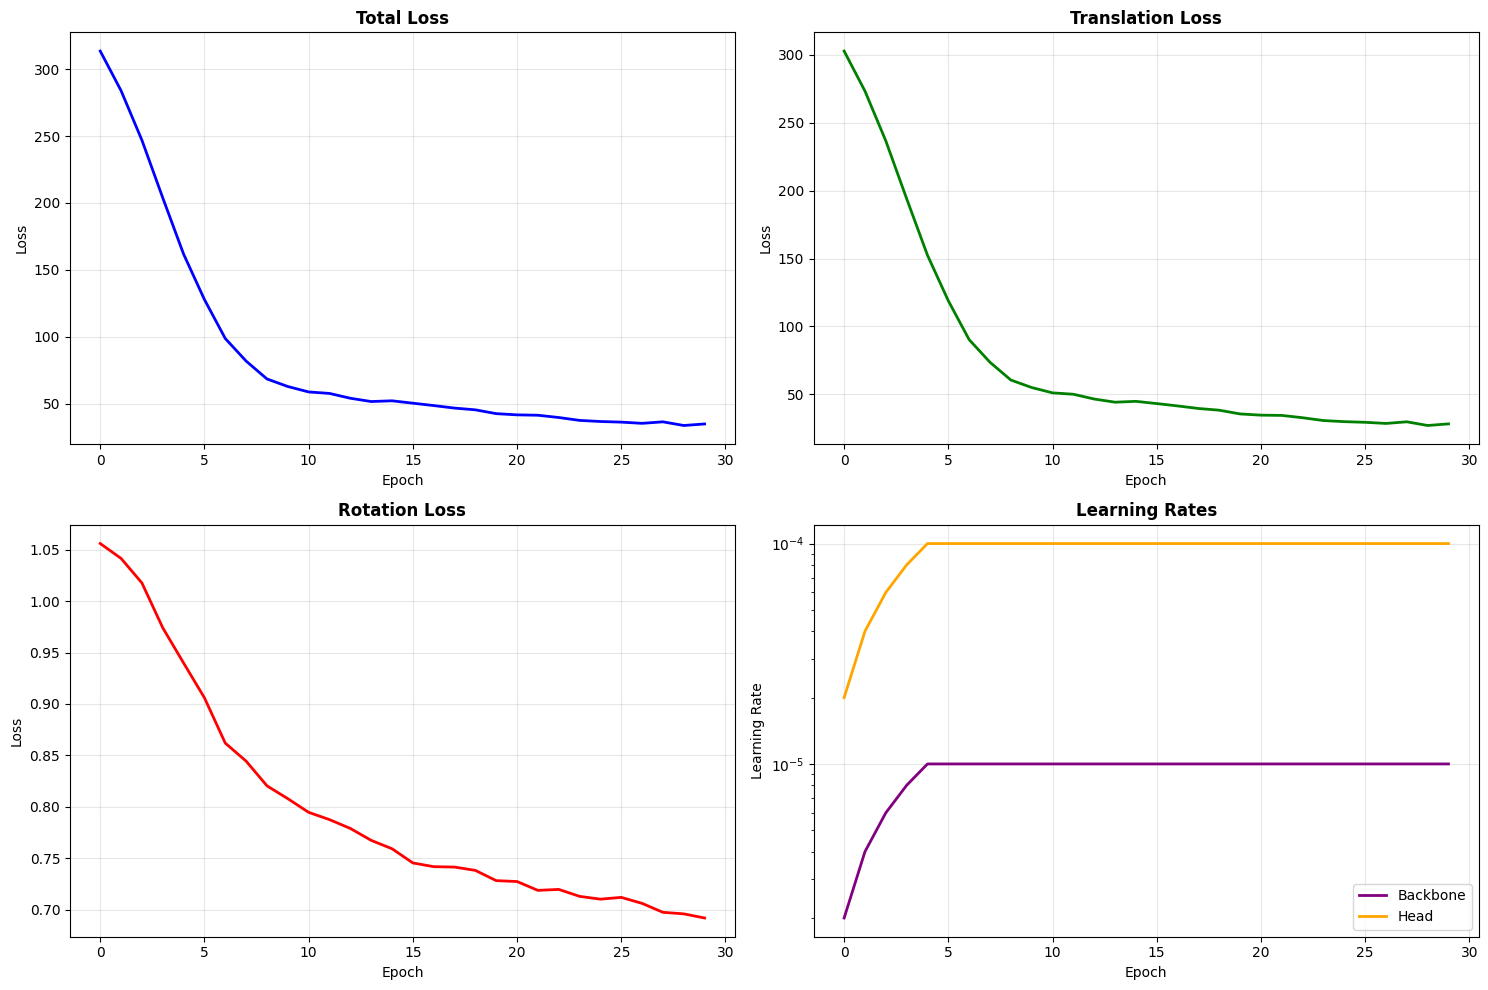

✅ Visualizzazione completata!

💡 Nota: Grafico LR mostra l'adattamento dinamico del learning rate


In [6]:
# Visualizza training curves con learning rates
print("📈 Visualizzazione training curves\n")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total loss
axes[0, 0].plot(history['train_loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Translation loss
axes[0, 1].plot(history['train_trans'], 'g-', linewidth=2)
axes[0, 1].set_title('Translation Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)

# Rotation loss
axes[1, 0].plot(history['train_rot'], 'r-', linewidth=2)
axes[1, 0].set_title('Rotation Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True, alpha=0.3)

# Learning rates
if 'lr_backbone' in history and 'lr_head' in history:
    axes[1, 1].plot(history['lr_backbone'], 'purple', linewidth=2, label='Backbone')
    axes[1, 1].plot(history['lr_head'], 'orange', linewidth=2, label='Head')
    axes[1, 1].set_title('Learning Rates', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizzazione completata!")
print(f"\n💡 Nota: Grafico LR mostra l'adattamento dinamico del learning rate")

### Carica Modello Trained

Carica il checkpoint salvato e testa su sample del test set.

In [8]:
# Carica il modello trained
try:
    LOAD_EXPERIMENT = EXPERIMENT_NAME
except NameError:
    LOAD_EXPERIMENT = "pose_stable_train30"

checkpoint_dir = project_root / 'checkpoints' / 'pose' / LOAD_EXPERIMENT
checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'

# Fallback ad altri esperimenti
if not checkpoint_path.exists():
    LOAD_EXPERIMENT = "pose_stable_train70"
    checkpoint_dir = project_root / 'checkpoints' / 'pose' / LOAD_EXPERIMENT
    checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'
    print(f"⚠️  Fase 1 non trovata, carico esperimento: {LOAD_EXPERIMENT}\n")

# Fallback al vecchio path se non esiste
if not checkpoint_path.exists():
    checkpoint_path = project_root / 'checkpoints' / 'pose_best_quick.pth'
    print(f"⚠️  Nuovo path non trovato, uso vecchio checkpoint: {checkpoint_path.name}\n")

if checkpoint_path.exists():
    print(f"✅ Carico checkpoint: {checkpoint_path.relative_to(project_root)}\n")
    
    # Inizializza modello se non già fatto
    if 'model' not in locals():
        model = PoseEstimator(
            pretrained=True,
            dropout=Config.POSE_DROPOUT,
            freeze_backbone=False  # ✅ Coerente con Fase 1
        ).to(Config.DEVICE)
    
    # Carica weights
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"📊 Checkpoint info:")
    print(f"   Epoch: {checkpoint['epoch'] + 1}")
    print(f"   Loss: {checkpoint['loss']:.4f}")
    if 'loss_trans' in checkpoint:
        print(f"   Trans Loss: {checkpoint['loss_trans']:.4f}")
        print(f"   Rot Loss: {checkpoint['loss_rot']:.2f}")
    if 'config' in checkpoint:
        print(f"\n📋 Training config:")
        for key, value in checkpoint['config'].items():
            print(f"      {key}: {value}")
    print(f"\n   Device: {Config.DEVICE}")
    print(f"\n✅ Modello caricato e in modalità eval!")
    
else:
    print(f"❌ Checkpoint non trovato: {checkpoint_path}")
    print(f"   Path cercati:")
    print(f"   1. {checkpoint_dir / 'weights' / 'best.pt'}")
    print(f"   2. {project_root / 'checkpoints' / 'pose_best_quick.pth'}")
    print(f"\n   Esegui prima il training Fase 1 (cella 9)")
    print(f"   Oppure cambia LOAD_EXPERIMENT con un esperimento esistente")

✅ Carico checkpoint: checkpoints/pose/pose_stable_train30/weights/best.pt



/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: ResNet-50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.3
📊 Checkpoint info:
   Epoch: 29
   Loss: 33.9162
   Trans Loss: 26.9577
   Rot Loss: 0.70

📋 Training config:
      phase: Phase 1 - Optimized
      epochs: 30
      warmup_epochs: 5
      lr_backbone: 1e-05
      lr_head: 0.0001
      batch_size: 128
      accumulation_steps: 4
      effective_batch_size: 512
      use_amp: False
      lambda_trans: 1.0
      lambda_rot: 10.0
      dropout: 0.3
      freeze_backbone: False
      scheduler: ReduceLROnPlateau
      device: mps
      image_size: 224
      crop_margin: 0.1

   Device: mps

✅ Modello caricato e in modalità eval!
📊 Checkpoint info:
   Epoch: 29
   Loss: 33.9162
   Trans Loss: 26.9577
   Rot Loss: 0.70

📋 Training config:
      phase: Phase 1 - Optimized
      epochs: 30
      warmup_epochs: 5
      lr_backbone: 1e-05
      lr_head: 0.0001
      batch_size:

### Test su Sample del Test Set

Visualizza predizioni vs ground truth su batch del test set.

🔍 Test su sample casuali del test set...

🎲 Batch casuale selezionato: 145/166

🎲 Batch casuale selezionato: 145/166



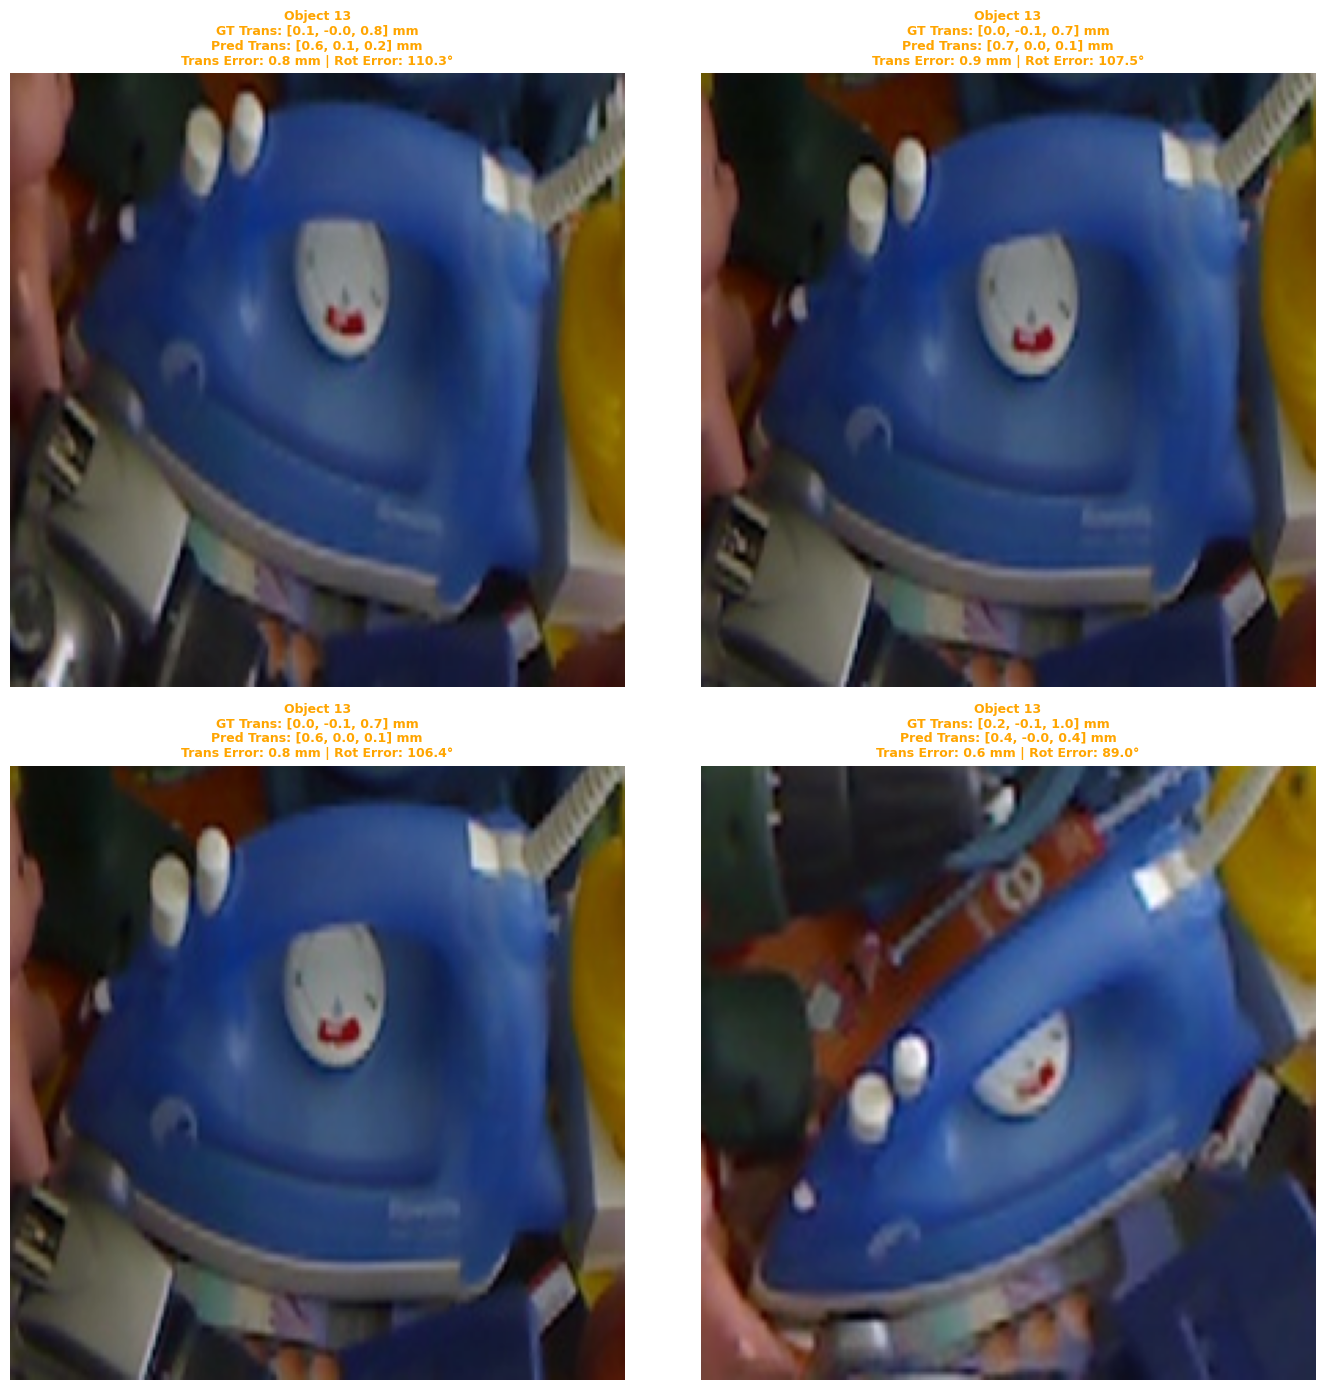

✅ Test completato su 128 sample

📊 Errori medi sul batch:
   Translation error: 0.83 ± 0.18 mm
   Rotation error: 112.56 ± 29.53°

💡 Interpretazione colori:
   🟢 Verde: Trans < 50mm e Rot < 10°
   🟠 Arancione: 50mm < Trans < 100mm
   🔴 Rosso: Trans > 100mm o Rot > 10°

🎲 Esegui di nuovo la cella per vedere altri sample casuali!


In [9]:
# Test su batch casuale del test set
import random

if 'model' in locals() and checkpoint_path.exists():
    print("🔍 Test su sample casuali del test set...\n")
    
    # ✅ Seleziona un batch casuale invece del primo
    random_batch_idx = random.randint(0, len(test_loader) - 1)
    for idx, batch in enumerate(test_loader):
        if idx == random_batch_idx:
            test_batch = batch
            break
    
    print(f"🎲 Batch casuale selezionato: {random_batch_idx + 1}/{len(test_loader)}\n")
    
    images = test_batch['rgb_crop'].to(Config.DEVICE)
    gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
    gt_translations = test_batch['translation'].to(Config.DEVICE)
    obj_ids = test_batch['obj_id']
    
    # Predizione
    with torch.no_grad():
        pred_quaternions, pred_translations = model(images)
    
    # Calcola errori
    trans_errors = torch.norm(pred_translations - gt_translations, dim=1).cpu().numpy()
    
    # Calcola rotation error (geodesic distance)
    dot_products = torch.sum(pred_quaternions * gt_quaternions, dim=1)
    dot_products = torch.clamp(torch.abs(dot_products), 0, 1)
    rot_errors = 2 * torch.acos(dot_products) * 180 / np.pi  # In gradi
    rot_errors = rot_errors.cpu().numpy()
    
    # Visualizza 4 sample
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()
    
    for i in range(min(4, len(images))):
        # Denormalizza immagine
        img = images[i].permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        # Ground truth e prediction
        gt_q = gt_quaternions[i].cpu().numpy()
        gt_t = gt_translations[i].cpu().numpy()
        pred_q = pred_quaternions[i].cpu().numpy()
        pred_t = pred_translations[i].cpu().numpy()
        obj_id = obj_ids[i].item()
        
        axes[i].imshow(img)
        title = (
            f"Object {obj_id:02d}\n"
            f"GT Trans: [{gt_t[0]:.1f}, {gt_t[1]:.1f}, {gt_t[2]:.1f}] mm\n"
            f"Pred Trans: [{pred_t[0]:.1f}, {pred_t[1]:.1f}, {pred_t[2]:.1f}] mm\n"
            f"Trans Error: {trans_errors[i]:.1f} mm | Rot Error: {rot_errors[i]:.1f}°"
        )
        
        # Colora in base all'errore
        color = 'green' if trans_errors[i] < 50 and rot_errors[i] < 10 else 'orange' if trans_errors[i] < 100 else 'red'
        axes[i].set_title(title, fontsize=9, color=color, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Test completato su {len(images)} sample")
    print(f"\n📊 Errori medi sul batch:")
    print(f"   Translation error: {trans_errors.mean():.2f} ± {trans_errors.std():.2f} mm")
    print(f"   Rotation error: {rot_errors.mean():.2f} ± {rot_errors.std():.2f}°")
    print(f"\n💡 Interpretazione colori:")
    print(f"   🟢 Verde: Trans < 50mm e Rot < 10°")
    print(f"   🟠 Arancione: 50mm < Trans < 100mm")
    print(f"   🔴 Rosso: Trans > 100mm o Rot > 10°")
    print(f"\n🎲 Esegui di nuovo la cella per vedere altri sample casuali!")
    
else:
    print("❌ Carica prima il modello (cella precedente)")


### Valutazione Completa con ADD Metric

Valutazione su tutto il test set con metrica ADD (Average Distance of Model Points).
ADD < 10% del diametro dell'oggetto è considerato corretto.

In [9]:
# Carica modelli 3D (.ply) e models_info
print("📦 Caricamento modelli 3D per ADD metric...\n")

models_dict = load_all_models(Config.MODELS_PATH)
models_info = load_models_info(Config.MODELS_INFO_PATH)

print(f"✅ Caricati {len(models_dict)} modelli 3D:")
for obj_id, points in models_dict.items():
    diameter = models_info[obj_id]['diameter']
    print(f"   Object {obj_id:02d}: {len(points):,} punti, diametro {diameter:.1f} mm")

print(f"\n📊 ADD threshold: {Config.ADD_THRESHOLD * 100:.0f}% del diametro")
print(f"   Esempio: se diametro = 100mm, threshold = 10mm")

📦 Caricamento modelli 3D per ADD metric...

✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 03: 40759 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 07: 16573 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points
✅ Caricati 15 modelli 3D:
   Object 01: 5,841 punti, diametro 102.1 mm
   Object 02: 38,325 punti, diametro 247.5 mm
   Object 03: 40,759 punti, diametro 167.4 mm
   Object 04: 18,995 punti, diametro 172.5 mm
   Object 05: 22,831 punti, diametro 201.4 mm
   Object 06: 15,736 punti, diametro 154.5 mm
   Object 07: 16,573 punti, diametro 124.3 mm
   Object 08: 12,655 punti, diametro 261.5 mm
   Object 09: 7,912 punti, diametro 109.0 mm
   Object 10: 18,473 punti, diametro 164.

In [10]:
# Valutazione completa con ADD metric
if 'model' in locals() and checkpoint_path.exists() and 'models_dict' in locals():
    print("🔍 Valutazione completa su test set con ADD metric...\n")
    print(f"⏳ Questo richiederà alcuni minuti...\n")
    
    model.eval()
    
    # Dizionari per raccogliere risultati per oggetto
    per_object_adds = {obj_id: [] for obj_id in Config.LINEMOD_OBJECTS}
    per_object_correct = {obj_id: 0 for obj_id in Config.LINEMOD_OBJECTS}
    per_object_total = {obj_id: 0 for obj_id in Config.LINEMOD_OBJECTS}
    
    all_adds = []
    
    # ✅ VALUTAZIONE COMPLETA - rimosso MAX_SAMPLES limit
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move to device
            images = batch['rgb_crop'].to(Config.DEVICE)
            gt_quaternions = batch['quaternion'].to(Config.DEVICE)
            gt_translations = batch['translation'].to(Config.DEVICE)
            obj_ids = batch['obj_id'].cpu().numpy()
            
            # Predizione
            pred_quaternions, pred_translations = model(images)
            
            # ✅ VETTORIZZATO: Converti batch di quaternion in batch di rotation matrices (10x speedup!)
            from utils.transforms import quaternion_to_rotation_matrix_batch
            
            pred_R = quaternion_to_rotation_matrix_batch(pred_quaternions).cpu().numpy()
            gt_R = quaternion_to_rotation_matrix_batch(gt_quaternions).cpu().numpy()
            
            pred_t = pred_translations.cpu().numpy()
            gt_t = gt_translations.cpu().numpy()
            
            # Calcola ADD per ogni sample nel batch (ritorna un dizionario)
            result = compute_add_batch(
                pred_R, pred_t, gt_R, gt_t,
                obj_ids, models_dict, models_info,
                threshold=Config.ADD_THRESHOLD,
                symmetric_objects=Config.SYMMETRIC_OBJECTS
            )
            
            # Estrai i valori dal dizionario
            adds = result['add_values']
            corrects = result['is_correct']
            
            # Accumula risultati per oggetto
            for i, obj_id in enumerate(obj_ids):
                per_object_adds[obj_id].append(adds[i])
                per_object_total[obj_id] += 1
                if corrects[i]:
                    per_object_correct[obj_id] += 1
                all_adds.append(adds[i])
    
    # Calcola statistiche globali
    mean_add = np.mean(all_adds)
    median_add = np.median(all_adds)
    std_add = np.std(all_adds)
    total_correct = sum(per_object_correct.values())
    total_samples = sum(per_object_total.values())
    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0
    
    # Calcola accuracy per oggetto
    per_object_accuracy = {}
    for obj_id in Config.LINEMOD_OBJECTS:
        if per_object_total[obj_id] > 0:
            per_object_accuracy[obj_id] = per_object_correct[obj_id] / per_object_total[obj_id]
        else:
            per_object_accuracy[obj_id] = 0
    
    # Stampa risultati
    print(f"\n{'='*80}")
    print(f"📈 RISULTATI VALUTAZIONE - ADD METRIC @ {Config.ADD_THRESHOLD * 100:.0f}% THRESHOLD")
    print(f"{'='*80}\n")
    
    print(f"🎯 Metriche Globali:")
    print(f"   Mean ADD: {mean_add:.2f} mm")
    print(f"   Median ADD: {median_add:.2f} mm")
    print(f"   Std ADD: {std_add:.2f} mm")
    print(f"   Overall Accuracy: {overall_accuracy * 100:.2f}%")
    print(f"   Correct: {total_correct} / {total_samples}")
    
    print(f"\n📋 Accuracy per Oggetto:")
    print(f"   {'Obj ID':<8} {'Accuracy':<12} {'Correct/Total':<15} {'Mean ADD (mm)':<15}")
    print(f"   {'-'*60}")
    
    for obj_id in sorted(Config.LINEMOD_OBJECTS):
        if per_object_total[obj_id] > 0:
            acc = per_object_accuracy[obj_id]
            mean_obj_add = np.mean(per_object_adds[obj_id])
            print(f"   {obj_id:<8} {acc*100:>6.2f}%      {per_object_correct[obj_id]:>4}/{per_object_total[obj_id]:<8}  {mean_obj_add:>12.2f}")
    
    # Interpretazione
    print(f"\n💡 Interpretazione:")
    if overall_accuracy > 0.7:
        print(f"   ✅ Ottimo! Accuracy > 70% indica pose estimation accurate")
    elif overall_accuracy > 0.5:
        print(f"   ✓  Buono! Accuracy > 50% indica pose discrete")
    elif overall_accuracy > 0.3:
        print(f"   ⚠️  Discreto. Accuracy > 30% ma potrebbe migliorare con più training")
    else:
        print(f"   ❌ Basso. Considerare 50 epoche con backbone unfrozen")
    
    print(f"\n✅ Valutazione completata su TUTTO il test set!")
    print(f"   Metriche accurate basate su {total_samples} sample totali")
    
else:
    print("❌ Carica prima il modello e i modelli 3D (celle precedenti)")

🔍 Valutazione completa su test set con ADD metric...

⏳ Questo richiederà alcuni minuti...



Evaluating:   8%|▊         | 14/166 [00:31<08:03,  3.18s/it]

Evaluating:  43%|████▎     | 72/166 [03:58<05:13,  3.33s/it]

Evaluating:  45%|████▍     | 74/166 [04:05<05:11,  3.39s/it]

Evaluating: 100%|██████████| 166/166 [08:33<00:00,  3.09s/it]


📈 RISULTATI VALUTAZIONE - ADD METRIC @ 10% THRESHOLD

🎯 Metriche Globali:
   Mean ADD: 46.07 mm
   Median ADD: 40.50 mm
   Std ADD: 28.08 mm
   Overall Accuracy: 16.75%
   Correct: 3555 / 21218

📋 Accuracy per Oggetto:
   Obj ID   Accuracy     Correct/Total   Mean ADD (mm)  
   ------------------------------------------------------------
   1          8.23%       168/2041             26.98
   2         12.12%       125/1031             61.69
   4          6.96%        71/1020             64.61
   5         10.93%       223/2041             52.49
   6         10.14%       204/2011             40.41
   8         89.07%      1817/2040             18.09
   9          4.82%        98/2033             39.34
   10         3.20%        66/2061             56.87
   11        21.12%       380/1799             29.99
   12         6.40%       133/2079             47.62
   13         6.23%        61/979              85.63
   14         8.16%        85/1042             72.44
   15        11.91%    

📊 Visualizzazione risultati ADD metric



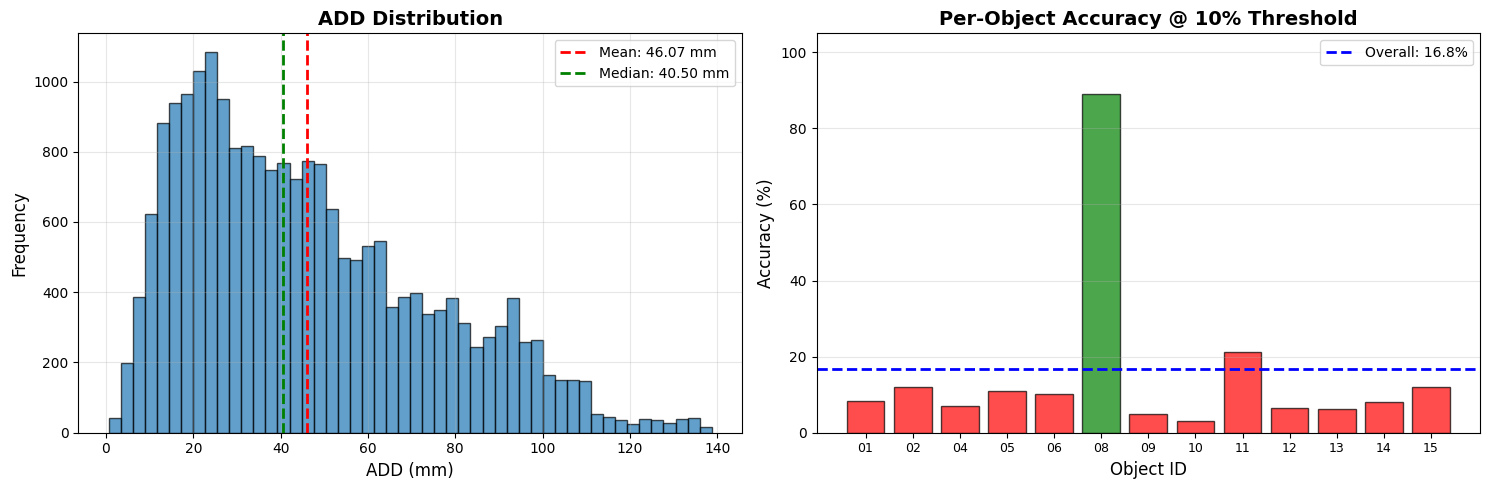

✅ Visualizzazione completata!

💡 Interpretazione colori (Accuracy bar chart):
   🟢 Verde: Accuracy > 70%
   🟠 Arancione: 50% < Accuracy < 70%
   🔴 Rosso: Accuracy < 50%


In [11]:
# Visualizza distribuzione ADD e accuracy per oggetto
if 'all_adds' in locals() and 'per_object_accuracy' in locals():
    print("📊 Visualizzazione risultati ADD metric\n")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # ADD distribution histogram
    axes[0].hist(all_adds, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(mean_add, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_add:.2f} mm')
    axes[0].axvline(median_add, color='green', linestyle='--', linewidth=2, label=f'Median: {median_add:.2f} mm')
    axes[0].set_xlabel('ADD (mm)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('ADD Distribution', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Per-object accuracy bar chart
    obj_ids = sorted(Config.LINEMOD_OBJECTS)
    accuracies = [per_object_accuracy[obj_id] * 100 for obj_id in obj_ids]
    colors = ['green' if acc > 70 else 'orange' if acc > 50 else 'red' for acc in accuracies]
    
    bars = axes[1].bar(range(len(obj_ids)), accuracies, color=colors, edgecolor='black', alpha=0.7)
    axes[1].axhline(overall_accuracy * 100, color='blue', linestyle='--', linewidth=2, label=f'Overall: {overall_accuracy*100:.1f}%')
    axes[1].set_xlabel('Object ID', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title(f'Per-Object Accuracy @ {Config.ADD_THRESHOLD*100:.0f}% Threshold', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(obj_ids)))
    axes[1].set_xticklabels([f'{obj_id:02d}' for obj_id in obj_ids], fontsize=9)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim([0, 105])
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualizzazione completata!")
    print(f"\n💡 Interpretazione colori (Accuracy bar chart):")
    print(f"   🟢 Verde: Accuracy > 70%")
    print(f"   🟠 Arancione: 50% < Accuracy < 70%")
    print(f"   🔴 Rosso: Accuracy < 50%")
    
else:
    print("❌ Esegui prima la valutazione completa (cella precedente)")

---

In [1]:
# 📊 VISUALIZZA ESPERIMENTI DISPONIBILI

import pandas as pd

pose_checkpoint_dir = project_root / 'checkpoints' / 'pose'

if pose_checkpoint_dir.exists():
    experiments = [d for d in pose_checkpoint_dir.iterdir() if d.is_dir()]
    
    if experiments:
        print(f"📁 Esperimenti disponibili ({len(experiments)}):\n")
        
        for exp_dir in sorted(experiments):
            exp_name = exp_dir.name
            args_file = exp_dir / 'args.yaml'
            results_file = exp_dir / 'results.csv'
            best_weights = exp_dir / 'weights' / 'best.pt'
            
            print(f"{'='*80}")
            print(f"📌 {exp_name}")
            print(f"{'='*80}")
            
            # Leggi configurazione
            if args_file.exists():
                with open(args_file, 'r') as f:
                    config = yaml.safe_load(f)
                print(f"⚙️  Configurazione:")
                print(f"   Epoche: {config.get('epochs', 'N/A')}")
                print(f"   Learning rate: {config.get('lr', 'N/A')}")
                print(f"   Batch size: {config.get('batch_size', 'N/A')}")
                print(f"   Backbone frozen: {config.get('freeze_backbone', 'N/A')}")
            
            # Leggi risultati
            if results_file.exists():
                df = pd.read_csv(results_file)
                print(f"\n📈 Risultati:")
                print(f"   Epoche completate: {len(df)}")
                print(f"   Best loss: {df['train_loss'].min():.4f} (epoch {df['train_loss'].idxmin() + 1})")
                print(f"   Last loss: {df['train_loss'].iloc[-1]:.4f}")
                print(f"   Trans loss: {df['train_trans_loss'].iloc[-1]:.4f}")
                print(f"   Rot loss: {df['train_rot_loss'].iloc[-1]:.2f}")
            
            # Controlla weights
            if best_weights.exists():
                weight_size = best_weights.stat().st_size / (1024 * 1024)
                print(f"\n💾 Checkpoint:")
                print(f"   Best weights: ✅ ({weight_size:.1f} MB)")
            else:
                print(f"\n💾 Checkpoint:")
                print(f"   Best weights: ❌ Non trovato")
            
            print()
    else:
        print("❌ Nessun esperimento trovato in checkpoints/pose/")
        print("   Esegui prima il training (cella 9)")
else:
    print("❌ Directory checkpoints/pose/ non esiste")
    print("   Esegui prima il training (cella 9)")

NameError: name 'project_root' is not defined